In [1]:
!pip install CoolProp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive/Thermo-thesis/')

In [4]:
from sCO2Utils import *
from config import Config

Critical Pressure is 73.773 ATM
Critical Temperature is 304.1282 K
The start at the saturation curve is at Temperature 223 K and Pressure 6.78 ATM
The saturation Pressure for T = 30C is 71.89 ATM


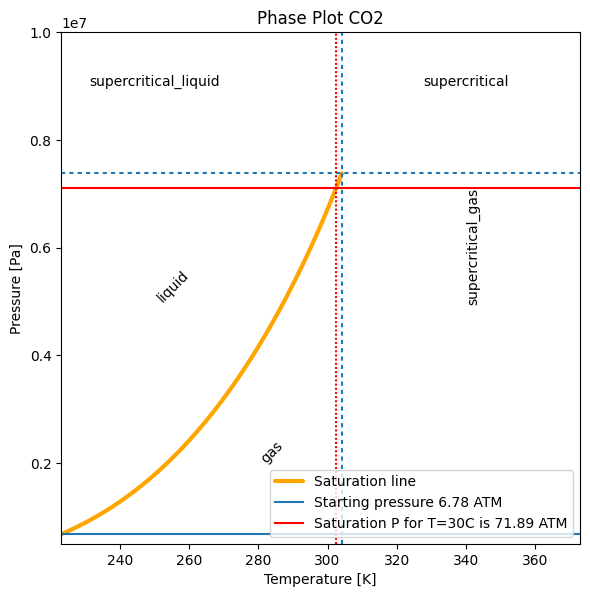

In [7]:
import scipy.interpolate

CO2 = CP.AbstractState("HEOS", "CO2")
pc = CO2.keyed_output(CP.iP_critical) ; print(f'Critical Pressure is {pc/1e5} ATM')
Tc = CO2.keyed_output(CP.iT_critical) ; print(f'Critical Temperature is {Tc} K')
N = 50 # Points where to calculate saturation line
Tmin = 273 - N
Tmax = 273+100
pmax = 1e7
p_min = 5e5
fillcolor = 'g'

# ----------------
# Saturation curve
# ----------------
Ts = np.linspace(Tmin, Tc, N)
ps = CP.CoolProp.PropsSI('P','T',Ts,'Q',0,'CO2')
print(f'The start at the saturation curve is at Temperature {Tmin} K and Pressure {"{:.2f}".format(ps[0]/1e5)} ATM')
# ------
# Labels
# ------
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
lw = 3

plt.plot(Ts,ps,'orange',lw = lw, solid_capstyle = 'round', label = 'Saturation line')
# Critical lines
plt.axvline(Tc, dashes = [2, 2])
plt.axhline(pc, dashes = [2, 2])

# Labels
plt.text(340, 9e6, 'supercritical',ha= 'center')
plt.text(340, 5e6, 'supercritical_gas', rotation = 90)
plt.text(250, 9e6, 'supercritical_liquid', rotation = 0, ha = 'center')
plt.text(250, 5e6, 'liquid', rotation = 45)
plt.text(280, 2e6, 'gas', rotation = 45)
#plt.text(550, 34e5, 'Start at saturation curve is at 34.7 ATM')

plt.ylim(p_min,pmax)
#plt.gca().set_yscale('log')
plt.gca().set_xlim(Tmin, Tmax)
plt.ylabel('Pressure [Pa]')
plt.xlabel('Temperature [K]')
plt.tight_layout()
plt.title('Phase Plot CO2')

P_sat = PropsSI('P','T',Config.T1,'Q',0,'CO2') # Saturation pressure at T = 30C
print(f'The saturation Pressure for T = 30C is {"{:.2f}".format(P_sat/1e5)} ATM')
plt.axhline(y=ps[0], label = f'Starting pressure {"{:.2f}".format(ps[0]/1e5)} ATM')

T_index = np.where(np.logical_and(Ts>=Config.T1-1, Ts<=Config.T1+1))
plt.axhline(y = ps[T_index][0], color = 'red', label = f'Saturation P for T={Config.T1 - 273}C is {"{:.2f}".format(P_sat/1e5)} ATM')
plt.axvline(x = Ts[T_index][0], color = 'red', dashes = [1,1])

plt.legend(loc ='lower right')


Critical pressure of CO2 is 73.77 ATM
The saturation pressure for CO2 at T = 30 C is 71.89 ATM

Thus we will use 71.9 ATM as starting pressure for Rankine

# Simulating ideal Rankine

Parameters chosen:
1. Ambient T = 10C
2. Warm Reservoir T = 100C
3. Max Pressure = 35MPa


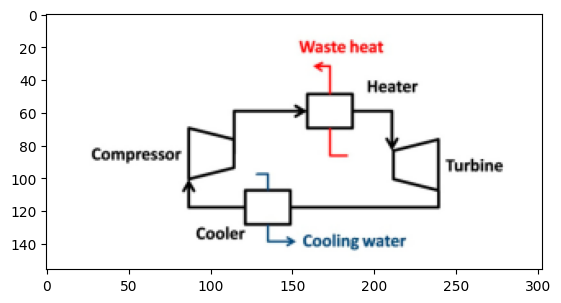

In [9]:
img = plt.imread('Simple_setup.png')
plt.imshow(img)

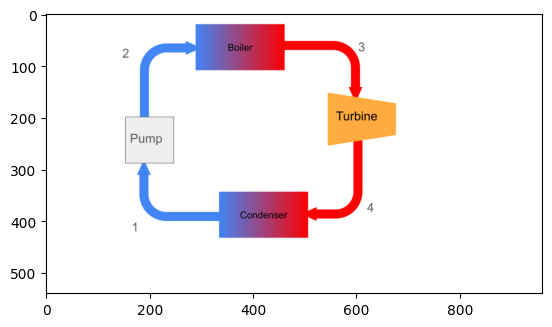

In [10]:
img = plt.imread('simple-Rankine.png')
plt.imshow(img)

In [11]:
def resolve_simple_cycle(
    P1 : float,
    rp : float,
    turbine_isentropic_efficiency : float,
    pump_isentropic_efficiency : float,
    T1 : float,
    T3 : float,
):

  P2 = P1*rp # Changing the pressure ratio

  turbine = Turbine(isentropic_efficiency=turbine_isentropic_efficiency,output_pressure=P1)
  pump = Pump(isentropic_efficiency=pump_isentropic_efficiency,output_pressure=P2)

  state1 = ThermodynamicState(p = P1,t = T1); state1.compute_from_p_t()
  state3 = ThermodynamicState(p = P2,t = T3); state3.compute_from_p_t()

  state2 = pump.resolve_actual_output_state(input_state = state1)
  state4 = turbine.resolve_actual_output_state(input_state = state3)

  qout = state4.h -state1.h
  qin = state3.h - state2.h
  eta_rankine = 1 - qout/qin

  return [eta_rankine, [state1,state2,state3,state4]]

In [53]:
# INITIAL CONDITIONS
P1 = Config.rankine_Pmin
T1 = Config.T1
T3 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency

In [54]:
rp_min = Config.rankine_rp_min
rp_max = Config.rankine_rp_max
N = 50 # points
rp_list = list(np.linspace(rp_min,rp_max,N+1))

rankine_efficiency_list = []
for rp in rp_list:
  rankine_efficiency_list.append(resolve_simple_cycle(
      P1 = P1,
      rp = rp,
      turbine_isentropic_efficiency= turbine_isentropic_efficiency,
      pump_isentropic_efficiency= pump_isentropic_efficiency,
      T1 = T1,
      T3 = T3
  )[0])

Text(0.5, 1.0, 'Efficiency vs Pressure Ratio Simple Rankine power cycle')

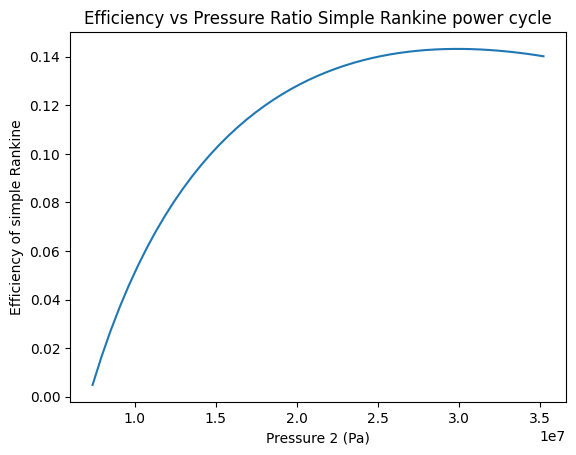

In [55]:
fig,ax = plt.subplots(1,1)
ax.plot(np.array(rp_list)*P1, rankine_efficiency_list)
ax.set_xlabel('Pressure 2 (Pa)')
ax.set_ylabel('Efficiency of simple Rankine')
ax.set_title("Efficiency vs Pressure Ratio Simple Rankine power cycle")

In [56]:
max_index = np.argmax(np.array(rankine_efficiency_list))
print(f'The maximum of Rankine efficiency of {"{:.2f}".format(rankine_efficiency_list[max_index]*100)} % is reached for rp = {rp_list[max_index]}')

The maximum of Rankine efficiency of 14.32 % is reached for rp = 4.126


In [57]:
# Pick the best performing pressure ratio
rp_best = rp_list[max_index]
_eta, rankine_states_list = resolve_simple_cycle(
      P1 = P1,
      rp = rp_best,
      turbine_isentropic_efficiency= turbine_isentropic_efficiency,
      pump_isentropic_efficiency= pump_isentropic_efficiency,
      T1 = T1,
      T3 = T3
  )

In [58]:
show_states_table(rankine_states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1      7190000.0       303.000000        302.929951          1.338232
2     29665940.0       349.018801        342.542713          1.361058
3     29665940.0       473.000000        570.742338          1.925387
4      7190000.0       352.457497        498.455899          1.962045


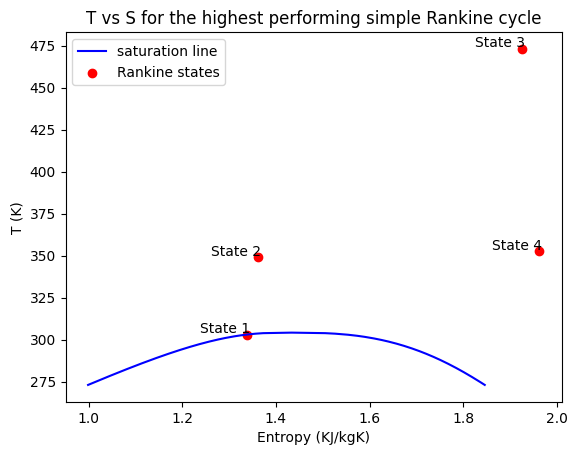

In [59]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing simple Rankine cycle')
rankine_state_xpoints = [state.s for state in rankine_states_list]
rankine_state_ypoints = [state.t for state in rankine_states_list]
ax.text(rankine_state_xpoints[0] - .1, rankine_state_ypoints[0] + 1,'State 1')
ax.text(rankine_state_xpoints[1] - .1, rankine_state_ypoints[1] + 1,'State 2')
ax.text(rankine_state_xpoints[2] - .1, rankine_state_ypoints[2] + 1,'State 3')
ax.text(rankine_state_xpoints[3] - .1, rankine_state_ypoints[3] + 1,'State 4')
ax.scatter(rankine_state_xpoints, rankine_state_ypoints, color = 'red', label = 'Rankine states')
ax.legend()

# Do the same for Brayton cycle

In [60]:
# INITIAL CONDITIONS for Brayton
P1 = Config.brayton_Pmin
T1 = Config.T1
T3 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency

In [61]:
rp_min = Config.brayton_rp_min
rp_max = Config.brayton_rp_max
N = 20 # points
rp_list = list(np.linspace(rp_min,rp_max,N+1))

brayton_efficiency_list = []
for rp in rp_list:
  brayton_efficiency_list.append(resolve_simple_cycle(
      P1 = P1,
      rp = rp,
      turbine_isentropic_efficiency= turbine_isentropic_efficiency,
      pump_isentropic_efficiency= pump_isentropic_efficiency,
      T1 = T1,
      T3 = T3
  )[0])

Text(0.5, 1.0, 'Efficiency vs Pressure Ratio Simple Brayton power cycle')

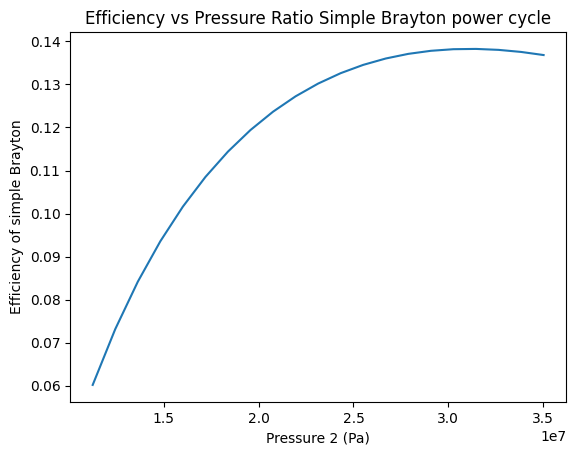

In [62]:
fig,ax = plt.subplots(1,1)
ax.plot(np.array(rp_list)*P1, brayton_efficiency_list)
ax.set_xlabel('Pressure 2 (Pa)')
ax.set_ylabel('Efficiency of simple Brayton')
ax.set_title("Efficiency vs Pressure Ratio Simple Brayton power cycle")

In [63]:
max_index = np.argmax(np.array(brayton_efficiency_list))
print(f'The maximum of efficiency of {"{:.2f}".format(brayton_efficiency_list[max_index]*100)} % is reached for rp = {rp_list[max_index]}, or P2 = {rp_list[max_index]*7.5} MPa')

The maximum of efficiency of 13.83 % is reached for rp = 4.1945, or P2 = 31.45875 MPa


In [64]:
# Pick the best performing pressure ratio
rp_best = rp_list[max_index]
_eta, brayton_states_list = resolve_simple_cycle(
      P1 = P1,
      rp = rp_best,
      turbine_isentropic_efficiency= turbine_isentropic_efficiency,
      pump_isentropic_efficiency= pump_isentropic_efficiency,
      T1 = T1,
      T3 = T3
  )

In [65]:
show_states_table(brayton_states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1      7500000.0       303.000000        290.458448          1.295477
2     31458750.0       343.894610        330.171510          1.318708
3     31458750.0       473.000000        566.710443          1.907300
4      7500000.0       351.613563        494.292526          1.944098


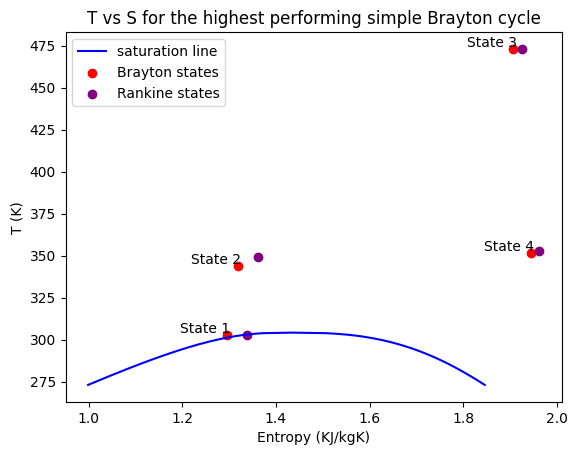

In [66]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing simple Brayton cycle')
brayton_state_xpoints = [state.s for state in brayton_states_list]
brayton_state_ypoints = [state.t for state in brayton_states_list]
ax.text(brayton_state_xpoints[0] - .1, brayton_state_ypoints[0] + 1,'State 1')
ax.text(brayton_state_xpoints[1] - .1, brayton_state_ypoints[1] + 1,'State 2')
ax.text(brayton_state_xpoints[2] - .1, brayton_state_ypoints[2] + 1,'State 3')
ax.text(brayton_state_xpoints[3] - .1, brayton_state_ypoints[3] + 1,'State 4')
ax.scatter(brayton_state_xpoints, brayton_state_ypoints, color = 'red', label = 'Brayton states')
ax.scatter(rankine_state_xpoints, rankine_state_ypoints, color = 'purple', label = 'Rankine states')
ax.legend()